# Activity: Develop a Multiclass Artificial Neural Network Image Classifier
In this activity, we'll develop a [Feed-Forward Neural Network (FNN)](https://en.wikipedia.org/wiki/Feedforward_neural_network) that classifies images of handwritten digits (0–9) from the [Modified National Institute of Standards and Technology (MNIST) database](https://en.wikipedia.org/wiki/MNIST_database). 

> __Learning Objectives:__
>
> By the end of this example, you should be able to:
> * **Build and train a multiclass feedforward neural network**: Construct an FNN using the Flux.jl library with multiple dense layers and activation functions for classifying images into 10-digit classes.
> * **Prepare image data for neural network training**: Convert grayscale images from matrix format to vectorized Float32 input with one-hot encoded labels.
> * **Evaluate model generalization on unseen data**: Compare classification accuracy on training and test datasets to assess overfitting and model performance.

Let's get started!
___

## Background: Feedforward Neural Networks for Image Classification
A feedforward neural network processes input through sequential layers of neurons, each applying a linear transformation followed by a nonlinear activation function. For image classification, the network learns to map pixel values to class probabilities.

> __Why FNNs for image classification?__
>
> * __Universal approximation__: FNNs with sufficient hidden neurons can approximate any continuous function, making them suitable for learning complex mappings from images to labels.
> * __Multiclass output__: The softmax activation in the output layer converts raw scores into a probability distribution over classes, enabling classification into one of multiple categories.
> * __Supervised batch learning__: FNNs learn their parameters from a fixed set of labeled examples by minimizing a loss function, providing stable training on well-curated datasets.

### Cross Entropy Loss Function
Given training data $\{(\mathbf{x}_{i}, \mathbf{y}_{i})\}_{i=1}^{N}$ where $\mathbf{x}_{i}\in\mathbb{R}^{d}$ is a vectorized image and $\mathbf{y}_{i}$ is the __one-hot encoded label__, the training minimizes the logit cross-entropy loss:
$$
\mathcal{L}(\theta) = -\frac{1}{N}\sum_{i=1}^{N}\underbrace{\left(\sum_{j=1}^{C} \underbrace{y_{ij}}_{\text{true}}\cdot\overbrace{\log(p_{ij}(\theta))}^{\text{predicted}}\right)}_{\text{each example}}
$$
where $C$ is the number of classes and $p_{ij}(\theta)$ is the predicted probability that example $i$ belongs to class $j$. We use gradient descent with momentum to update the parameters iteratively.
___

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources such as sample datasets, and setting up any required constants. 

> The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Otherwise, packages are downloaded and then loaded.

In [1]:
include("Include.jl")

### Load the MNIST digits data set
Before training and testing the FNN, we construct two datasets. First, we build a training dataset of images to estimate the model parameters, stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable. Next, we construct a test dataset to evaluate how well the FNN generalizes to data it has never seen, stored in the `testing_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.

> __Data format:__ The first element of each tuple is the input data $\mathbf{x}$ (the image pixels arranged as a vector), and the second element is the label (whether the image corresponds to digits 0–9).
>
> __Type considerations:__ The floating-point precision is `Float32` rather than the default `Float64` to reduce memory usage. The labels are [one-hot encoded](https://en.wikipedia.org/wiki/One-hot), and the input data is stored as a vector rather than a matrix (even though the original image is a $28\times 28$ matrix of grayscale values).

Before loading the testing and training data, let's set some constants. The comment next to each constant describes its permissible values, units, etc.

In [2]:
number_of_examples = 3000; # how many training examples of *each* number to include from the library
number_of_test_examples = 500; # how many examples are we going to test on?
number_of_training_examples = number_of_examples - number_of_test_examples; # how many training examples of *each* number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?

#### Load training and testing images
Unhide the code blocks below to see how we construct and populate the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable. 

We load `number_of_training_examples::Int` images into the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` and then later convert these to vector format by linearizing the $28\times 28$ matrix of grayscale values into a vector of 784 pixels.

In [3]:
digits_image_dictionary = MyMNISTHandwrittenDigitImageDataset(number_of_examples = number_of_examples);

What's in the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` variable?

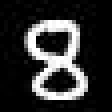

In [4]:
digits_image_dictionary[8][ :, :, 10] # how does the indexing work? This is the 10th example of the digit "8"

Next, let's partition the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` into training and testing datasets. We randomly select `number_of_training_examples::Int` images per digit for training, and the remaining images are used for testing. In each case, we convert the $28\times 28$ images into vector format by linearizing the matrix into a vector of 784 pixels.

Let's start with the training dataset. 

> __What is vectorization?__ Each $N\times N$ image array containing grayscale values at each pixel is converted to an $N^{2}$ vector by concatenating pixel values. The image class (the digit it represents) is converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). 
>
> __Why Float32?__ Most neural network libraries use `Float32` (or lower precision) to save memory because of the large number of parameters in the network. Additionally, model training is often carried out using specialized hardware such as [Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/), which have different memory constraints.

Let's save the training data in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.

In [5]:
training_image_dataset = let

    # initialize -
    training_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}();
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # what image class is this?
        X = digits_image_dictionary[i]; # this gets ALL images of digit "i"

        for t ∈ 1:number_of_training_examples
            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec |> x -> convert.(Float32,x); # flatten and convert to Float32
            training_tuple = (D,Y); # create training tuple (image data, image class)
            push!(training_image_dataset,training_tuple);
        end

    end
    training_image_dataset; # return
end

25000-element Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}:
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03137255, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007843138, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529412  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007843138  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015686275  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023529412 

What's in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable?

In [6]:
training_image_dataset[1] # what does the first training example look like? (image data, one-hot label)

(Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Next, we load `number_of_test_examples::Int` images from the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` for testing purposes. We save the test data in the `testing_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.

In [7]:
testing_image_dataset = let
    
    # initialize -
    testing_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    
    # main -
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # what image class is this?
        X = digits_image_dictionary[i]; # this gets ALL images of digit "i"
        
        for t ∈ (number_of_training_examples+1):number_of_examples

            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec |> x -> convert.(Float32,x); # flatten and convert to Float32
            testing_tuple = (D,Y); # create testing tuple (image data, image class)
            push!(testing_image_dataset, testing_tuple);
        end
    end

    testing_image_dataset; # return
end;

What's in the `testing_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable?

In [8]:
testing_image_dataset[1] # what does the first test example look like? (image data, one-hot label)

(Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

___

## Task 1: Build the model structure and train the network
In this task, we construct and train a feedforward model by learning the model parameters using example images encoded in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}`. 

> __Supervised batch learning:__ This is an example of supervised batch learning where the model learns its parameters on a fixed set of labeled examples. Unlike online learning approaches (such as the perceptron), there is no incremental update rule. Once the parameters are estimated, new data cannot be easily incorporated without retraining.

Let's start by getting the `number_of_input_states::Int`; this will be the input dimension of the first layer in our model:

In [9]:
number_of_input_states = length(training_image_dataset[1][1])

784

Next, we build an empty model with default (random) parameter values but a fixed structure. The number and dimension of the layers and the activation functions for each layer are specified when we build the model (but we update the parameters during training).

> __Library:__ We use [the Flux.jl machine learning library](https://github.com/FluxML/Flux.jl) to construct the neural network model. The model has three layers: an input layer of dimension $784\times 512$ with [ReLU activation functions](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), a hidden layer of dimension $512\times 10$, and an output layer using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function).
>
> __Syntax:__ The Flux.jl package uses specialized syntax. The model is built using [the `Chain` function](https://fluxml.ai/Flux.jl/stable/reference/models/layers/#Flux.Chain), which takes a list of layers as input. Each layer is defined using the [`Dense` type](https://fluxml.ai/Flux.jl/stable/reference/models/layers/#Flux.Dense), which takes the number of input and output neurons as arguments. The activation function is an additional argument to the `Dense` type. The final layer uses [the `softmax(...)` method exported by the NNlib.jl package](https://fluxml.ai/NNlib.jl/dev/reference/#Softmax) to produce a probability distribution over the classes.

We save the (untrained) model in the `model::Chain` variable.

In [10]:
Flux.@layer MyFluxNeuralNetworkModel; # create a layer type for our model
MyModel() = MyFluxNeuralNetworkModel( # define a constructor function
    Chain(
        Dense(number_of_input_states, 512, relu),  # layer 1
        Dense(512, 10, relu), # layer 2
        NNlib.softmax) # layer 3 (output layer)
);
model = MyModel().chain; # this is our model with untrained parameters

Next, we specify the loss function we will minimize to estimate the model parameters. We choose a loss function appropriate for a multiclass classification problem, namely a [logit cross-entropy loss function](https://fluxml.ai/Flux.jl/stable/reference/models/losses/#Flux.Losses.logitcrossentropy):

In [11]:
# Setup a loss function -
loss(ŷ, y) = Flux.Losses.logitcrossentropy(ŷ, y; 
    agg = mean); # loss for training multiclass classifiers, what is the agg?

We use [gradient descent with momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) where the $\lambda$ parameter denotes the learning rate and $\beta$ denotes the momentum parameter. We save information about the optimizer in the `opt_state` variable, which will be passed to the training method.

> __Why this optimizer?__ We could have chosen from many possible training approaches. The [Flux.jl library supports many optimizers](https://fluxml.ai/Flux.jl/stable/reference/training/optimisers/#Optimisers-Reference), all of which are variants of gradient descent. However, there is no technical reason we couldn't use an optimizer that doesn't rely on computing the gradient of the loss function. For example, we could use a genetic algorithm or other optimization method. However, these methods are typically less efficient than gradient descent for this type of problem.

This approach works well for our purposes. We'll explore more sophisticated training strategies in CHEME-5820!

In [12]:
λ = 0.01; # learning rate
β = 0.90; # momentum parameter
opt_state = Flux.setup(Momentum(λ, β), model);

__Training:__ We are now ready to train the model. If the flag `should_we_train::Bool = true`, we use [gradient descent with momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) to minimize the [logit cross-entropy loss function](https://fluxml.ai/Flux.jl/stable/reference/models/losses/#Flux.Losses.logitcrossentropy).

> __Restart strategy:__ Because the error landscape is non-convex, we need to explore from different starting points. We perform `number_of_epochs::Int` passes through the data, each consisting of a forward pass for prediction and a backpropagation step for parameter updates.
>
> __Checkpointing:__ Training takes considerable time. For each complete pass through the data (each epoch), we save a temporary file holding the network state as a checkpoint. A pre-trained model is loaded if the `should_we_train::Bool` flag is set to `false`.

In [13]:
should_we_train = false; # set this flag to {true | false}
if (should_we_train == true)
    number_of_epochs = 250; # how many epochs do we want to train for?
    
    @showprogress dt=1 desc="Training model..." for i = 1:number_of_epochs
        
        # train the model -
        Flux.train!(model, training_image_dataset, opt_state) do m, x, y
            loss(m(x), y)
        end
    
        # output some stuff -
        ridx = rand(1:number_of_training_examples);
        test_x, test_y = training_image_dataset[ridx][1], training_image_dataset[ridx][2];
        l = loss(model(test_x), test_y);
        println("Training example: $(ridx) has loss = $(l) in epoch $(i)");
    
        # save the state of the model, in case something happens. We can reload from this state
        jldsave("tmp-model-training-checkpoint.jld2", model_state = Flux.state(model))    
    end
else
    # if we don't train: load up a previous model
    model_state = JLD2.load("model-state-T3000-P500-E250-N512.jld2", "model_state");
    Flux.loadmodel!(model, model_state);
end

Chain(
  Dense(784 => 512, relu),              # 401_920 parameters
  Dense(512 => 10, relu),               # 5_130 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 407_050 parameters, 1.553 MiB.

___

## Task 2: How well does the model predict unseen versus observed images?
In this task, we assess the network's generalization by measuring how well it performs on data it has not seen. One challenge with [neural networks](https://en.wikipedia.org/wiki/Neural_network_(machine_learning)) is their potential lack of generalizability: they may not perform well on data not observed during training.

Let's explore this question by computing the fraction of images correctly classified on both the training and test datasets. We expect high accuracy on training data since the model has seen these examples. For the test data (unseen examples), we expect the accuracy to be at most equal to the training accuracy.

### Correct prediction on training dataset
In the code block below, we pass the pixel data from each image into the `model::Chain` instance, compute the predicted label $\hat{y}$, and compare the predicted and actual labels for the training dataset.

> __Evaluation logic:__ If the prediction and actual label agree, we update the running count of correct predictions. We then compute the fraction of correct classifications by dividing the number of correct predictions by the total number of images in the training dataset.

So, how well did we do on the __training dataset__?

In [14]:
let
    S_training = 0;
    for i ∈ eachindex(training_image_dataset)
    
        x = training_image_dataset[i][1];
        y = training_image_dataset[i][2];
        ŷ = model(x) |> z-> argmax(z) |> z-> number_digit_array[z] |> z-> onehot(z,number_digit_array)
        y == ŷ ? S_training +=1 : nothing
    end
    correct_prediction_training = (S_training/length(training_image_dataset))*100;
    println("Correct prediction % on the training data: $(correct_prediction_training)%");
end

Correct prediction % on the training data: 89.94%


### Correct prediction on test dataset
In the code block below, we pass the pixel data from each image into the `model::Chain` instance, compute the predicted label $\hat{y}$, and compare the predicted and actual labels for the test dataset. 

> __Evaluation logic:__ If the prediction and actual label agree, we update the running count of correct predictions. We then compute the fraction of correct classifications by dividing the number of correct predictions by the total number of images in the test dataset.

Is the model test accuracy comparable to the training accuracy?

In [15]:
let

    # initialize -
    S_testing = 0;

    # count correct predictions -
    for i ∈ eachindex(testing_image_dataset)
    
        x = testing_image_dataset[i][1];
        y = testing_image_dataset[i][2];
        ŷ = model(x) |> z-> argmax(z) |> z-> number_digit_array[z] |> z-> onehot(z, number_digit_array)
        y == ŷ ? S_testing+=1 : nothing
    end
    correct_prediction_test = (S_testing/length(testing_image_dataset))*100;
    println("Correct prediction on the test data: $(correct_prediction_test)%");
end

Correct prediction on the test data: 89.9%


### Examples
Let's examine a few manual examples to see what the model predicts. In the code block below, we take random images from the `testing_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` and compare the predicted and actual labels in one-hot format. If the prediction is wrong, we display the actual image and the predicted label.

In [16]:
let
    
    N = length(testing_image_dataset); # how many test examples
    i = rand(1:N) # select a random test example
    x = testing_image_dataset[i][1]; # get the input for this test example
    y = testing_image_dataset[i][2]; # get the *actual* output for this test example (onehot encoding)
   
    # compute onehot encoding of the predicted output -
    ŷ = model(x) |> z-> argmax(z) |> z-> number_digit_array[z] |> z-> onehot(z, number_digit_array)
    flag = y == ŷ # check that the predicted output is the same as the actual output
    if (flag == false)
        println(ŷ) # onehot encoding of the *predicted* output
        display(reshape(x, number_of_rows, number_of_cols) |> X -> Gray.(transpose(X))); # actual image
    end
end

___

## Summary
This example demonstrates building, training, and evaluating a feedforward neural network for multiclass image classification using the MNIST dataset.

> __Key Takeaways:__
>
> * **Feedforward networks for classification:** FNNs with dense layers and activation functions map vectorized image inputs to class probabilities. The softmax output layer converts raw scores into a probability distribution over the 10 digit classes.
> * **Data preparation matters:** Converting images to vectorized Float32 format with one-hot encoded labels enables efficient batch training. Using Float32 precision reduces memory requirements for large networks.
> * **Generalization assessment:** Comparing accuracy on training data versus unseen test data reveals whether the model has learned generalizable patterns or has overfit to the training examples.

Feedforward neural networks provide a foundation for more complex architectures such as convolutional neural networks for image tasks and recurrent neural networks for sequential data.

___